In [1]:
import numpy as np 
import pandas as pd 
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import acf
from math import sqrt


In [2]:
train_clinical_data = pd.read_csv("/kaggle/input/parkinson-data-3/train_clinical_data.csv")
train_peptides = pd.read_csv("/kaggle/input/parkinson-data-3/train_peptides.csv")
train_protiens = pd.read_csv("/kaggle/input/parkinson-data-3/train_proteins.csv")
supplemental_clinical_data = pd.read_csv("/kaggle/input/parkinson-data-3/supplemental_clinical_data.csv")
train = pd.concat([train_clinical_data, supplemental_clinical_data], ignore_index=True)

In [3]:
train

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
4833,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN
4834,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN
4835,65405_5,65405,5,NaN,NaN,57.0,NaN,NaN
4836,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN


In [4]:
obs_count = train.groupby("patient_id")['updrs_1'].count()
max_obs_patient = obs_count.idxmax()
print("Patient with the highest number of observations:", max_obs_patient)

Patient with the highest number of observations: 15009


In [5]:
df_15009 = train[train['patient_id'] == 15009]

In [6]:
df_15009_final = df_15009[['visit_id','updrs_1']]

In [7]:
len(df_15009_final)

17

In [8]:
train_df = df_15009_final[:14]
train_df

,visit_id,updrs_1
579,15009_0,8.0
580,15009_3,7.0
581,15009_6,10.0
582,15009_9,5.0
583,15009_12,4.0
584,15009_18,4.0
585,15009_24,5.0
586,15009_30,5.0
587,15009_36,5.0
588,15009_42,4.0


In [9]:
test_df = df_15009_final.iloc[-3:, :]
test_df

,visit_id,updrs_1
593,15009_84,10.0
594,15009_96,18.0
595,15009_108,12.0


In [10]:
result = adfuller(train_df['updrs_1'])
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

Test Statistic: -3.0442298218944757
p-value: 0.03096529433707305


train_df is stationary time series dataframe

<Axes: xlabel='visit_id'>

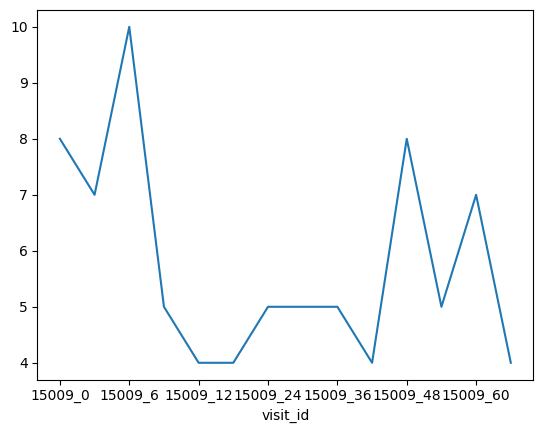

In [11]:
train_df = train_df.set_index('visit_id')
train_df['updrs_1'].plot()



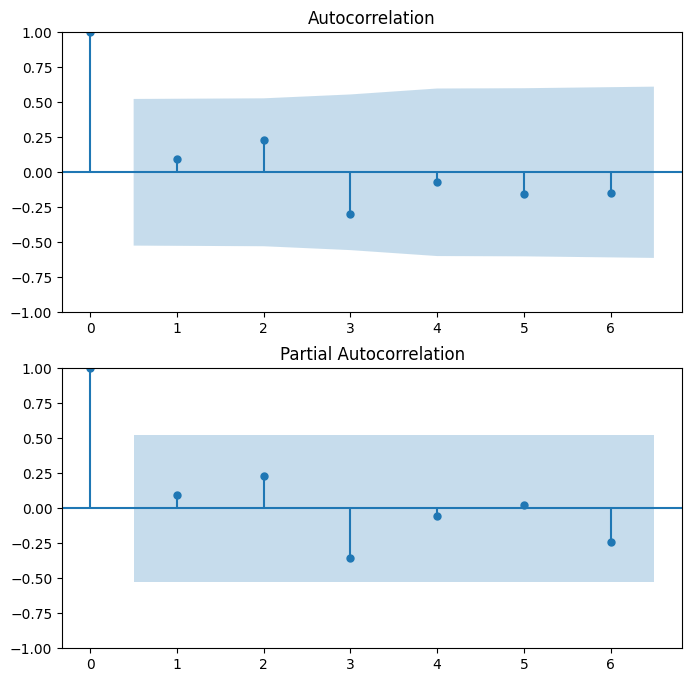

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(train_df, ax=ax1, lags=6)
plot_pacf(train_df, ax=ax2, lags=6)
plt.show()

In [13]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.8 MB/s eta 0:00:00:00:01


In [14]:
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [16]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit model
model = auto_arima(train_df['updrs_1'], start_p=0, start_d=0, start_q=1,
                   max_p=6, max_d=1, max_q=6, seasonal=False, trace=True)

print(model.summary())

# Predictions
predictions = model.predict(n_periods=len(test_df))

# Evaluation
mae = mean_absolute_error(test_df['updrs_1'], predictions)
rmse = mean_squared_error(test_df['updrs_1'], predictions, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)


Performing stepwise search to minimize aic
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=85.391, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=92.202, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=69.846, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=67.419, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=69.395, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=67.884, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=63.521, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=62.357, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=60.493, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=62.406, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=64.248, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.825 seconds
                               SARIMAX Results        

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [17]:
model_1 = sm.tsa.ARIMA(train_df, order=(4, 0, 5))
results_1 = model_1.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a 

In [18]:
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                updrs_1   No. Observations:                   14
Model:                 ARIMA(4, 0, 5)   Log Likelihood                 -22.968
Date:                Sat, 25 Oct 2025   AIC                             67.936
Time:                        12:29:01   BIC                             74.966
Sample:                             0   HQIC                            67.286
                                 - 14                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4426      0.220     24.758      0.000       5.012       5.873
ar.L1         -0.0303      2.286     -0.013      0.989      -4.510       4.449
ar.L2          0.6427      0.873      0.736      0.461      -1.068       2.353
ar.L3         -0.5488      0.641     -0.857      0.392      -1.804       0.707
ar.L4         -0.2230      1.272     -0.175      0.861      -2.716       2.270
ma.L1         -0.1685   2448.176  -6.88e-05      1.000   -4798.504    4798.167
ma.L2         -0.7313   1931.892     -0.000      1.000   -3787.170    3785.708
ma.L3         -0.7564    203.381     -0.004      0.997    -399.376     397.863
ma.L4         -0.1342   2094.588  -6.41e-05      1.000   -4105.451    4105.183
ma.L5          0.9838   2309.594      0.000      1.000   -4525.737    4527.705
sigma2         0.7148   1677.142      0.000      1.000   -3286.423    3287.853
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.95   Prob(JB):                         0.58
Heteroskedasticity (H):               0.33   Skew:                             0.45
Prob(H) (two-sided):                  0.25   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+17. Standard errors may be unstable.
"""

In [19]:
preds = results_1.forecast(steps=len(test_df))
preds = pd.DataFrame(preds)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [20]:
preds['visit_id'] = ["15009_84","15009_96","15009_108"]

In [21]:
preds = preds.set_index('visit_id')

In [22]:
test_df

,visit_id,updrs_1
593,15009_84,10.0
594,15009_96,18.0
595,15009_108,12.0


In [23]:
mae = mean_absolute_error(test_df['updrs_1'], preds)
rmse = sqrt(mean_squared_error(test_df['updrs_1'], preds))

print("Mean absolute error: ", mae)
print("Root mean squared error: ", rmse)

Mean absolute error:  7.614857385340765
Root mean squared error:  8.614682462092892


In [24]:
test_df = test_df.set_index('visit_id')

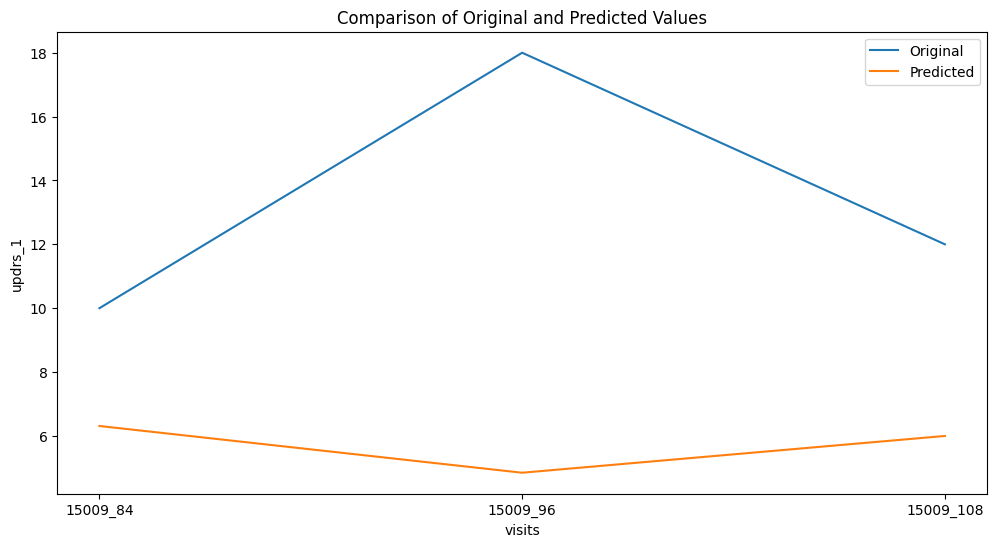

In [25]:
plt.figure(figsize=(12,6))
plt.plot(test_df.index, test_df.values, label='Original')
plt.plot(preds.index, preds.values, label='Predicted')
plt.title('Comparison of Original and Predicted Values')
plt.xlabel('visits')
plt.ylabel('updrs_1')
plt.legend()
plt.show()

In [26]:
model_2 = sm.tsa.ARIMA(train_df, order=(0, 0, 0))
results_2 = model_2.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a 

In [27]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                updrs_1   No. Observations:                   14
Model:                          ARIMA   Log Likelihood                 -28.246
Date:                Sat, 25 Oct 2025   AIC                             60.493
Time:                        12:29:37   BIC                             61.771
Sample:                             0   HQIC                            60.374
                                 - 14                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7857      0.669      8.649      0.000       4.475       7.097
sigma2         3.3112      1.882      1.760      0.078      -0.377       6.999
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.70   Prob(JB):                         0.39
Heteroskedasticity (H):               0.48   Skew:                             0.89
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
preds_2 = results_2.forecast(steps=len(test_df))
preds_2 = pd.DataFrame(preds_2)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [29]:
preds_2['visit_id'] = ["15009_84","15009_96","15009_108"]

Mean absolute error:  7.5476237690236845
Root mean squared error:  8.277812519880289


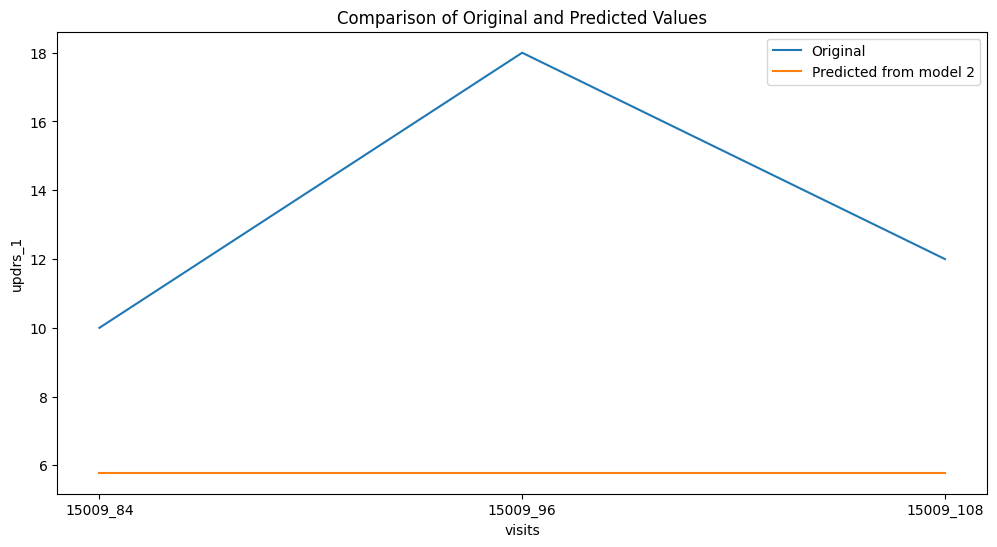

In [30]:
preds_2 = preds_2.set_index('visit_id')
mae = mean_absolute_error(test_df['updrs_1'], preds_2)
rmse = sqrt(mean_squared_error(test_df['updrs_1'], preds_2))

print("Mean absolute error: ", mae)
print("Root mean squared error: ", rmse)


plt.figure(figsize=(12,6))
plt.plot(test_df.index, test_df.values, label='Original')
plt.plot(preds_2.index, preds_2.values, label='Predicted from model 2')
plt.title('Comparison of Original and Predicted Values')
plt.xlabel('visits')
plt.ylabel('updrs_1')
plt.legend()
plt.show()